# Приоритизация гипотез для отдела маркетинка и проведение A/B теста

## Описание

**Название проекта:** "Приоритизация гипотез  и проведение A/B теста"

**Цель исследования:** Приоритизация гипотез, проведение A/B-теста и анализ его результатов.

Исследование состоит из 3х частей, описания и вывода.

**План исследования:**  
1. Изучение общей информации и подготовка данных
     
2. Приоритизация гипотез
- Применим фреймворк ICE для приоритизации гипотез.
- Применим фреймворк RICEдля приоритизации гипотез.   
- Объясним изменение в приоритизации гипотез по RICE и ICE.
  
3. Анализ A/B-теста  
    1. На основе результатов проведенного A/B-тест проанализируем:  
        1. Кумулятивные характеристики:  
        	- График кумулятивной выручки по группам.  
        	- График кумулятивного среднего чека по группам.  
        	- График относительного изменения кумулятивного среднего чека группы B к группе A.  
        	- График кумулятивного среднего количества заказов на посетителя по группам.  
        	- График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.  
        2. Колличественные характеристики:
        	- Построим точечный график количества заказов по пользователям.  
        	- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя, выберем границу для определения аномальных пользователей.  
        	- Построим точечный график стоимостей заказов.  
        	- Посчитаем 95-й и 99-й перцентили стоимости заказов, выберем границу для определения аномальных заказов.
        3. Статистическую значимость:
        	- Различия в среднем количестве заказов на посетителя между группами по «сырым» данным.  
        	- Различия в среднем чеке заказа между группами по «сырым» данным..
        	- Различия в среднем количестве заказов на посетителя между группами по «очищенным» данным.  
        	- Различия в среднем чеке заказа между группами по «очищенным» данным.   
    2. Принятие решения по результатам теста с объяснием. 

**Описание данных:**  
Совместно отделами маркетинга и аналитики был подгтовлен список гипотез для увеличения выручки нашего интернет-магазина.  

1. Файл /datasets/hypothesis.csv.   
- Hypothesis— краткое описание гипотезы;
- Reach— охват пользователей по 10-балльной шкале;
- Impact— влияние на пользователей по 10-балльной шкале;
- Confidence— уверенность в гипотезе по 10-балльной шкале;
- Efforts— затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
2. Файл /datasets/orders.csv.   
- transactionId— идентификатор заказа;
- visitorId— идентификатор пользователя, совершившего заказ;
- date— дата, когда был совершён заказ;
- revenue— выручка заказа;
- group— группа A/B-теста, в которую попал заказ.
3. Файл /datasets/visitors.csv.   
- date— дата;
- group— группа A/B-теста;
- visitors— количество пользователей в указанную дату в указанной группе A/B-теста

## 1. Изучение общей информации и подготовка данных

Импортирyем необходимые для анализа библиотеки и загрузим данные в датафрейм.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# сделаем просмотр более удобным
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# чтение файлов и сохранение df
try:
    hypothesis, orders, visitors = (
        pd.read_csv('C:/Users/iamst/Downloads/hypothesis.csv'),
        pd.read_csv('C:/Users/iamst/Downloads/orders.csv'),
        pd.read_csv('C:/Users/iamst/Downloads/visitors.csv'))
except:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv'))

Посмотрим названия столбцов в имеющихся данных.

In [4]:
display( 
    hypothesis.columns.values,
    orders.columns.values, 
    visitors.columns.values )

array(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'],
      dtype=object)

array(['transactionId', 'visitorId', 'date', 'revenue', 'group'],
      dtype=object)

array(['date', 'group', 'visitors'], dtype=object)

Приведем названия к обепринятому регистру.

In [5]:
hypothesis = hypothesis.rename(columns=str.lower)
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

Просмотрим основную информацию о датафреймах, одновременно проверим результат изменения названий столбцов и выведем несколько строк для обзора данных.

In [6]:
hypothesis.info()
hypothesis.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [7]:
orders.info()
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
visitors.info()
visitors.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Мы видим, что пропусков в данных нет, а так же что столбцы успешно переименовались.  
Еше необходимо поменять тип данных на корректный для столбцов где содержатся даты и проверить наличие дубликатов.

In [9]:
display(
    visitors.duplicated().sum()+
    orders.duplicated().sum()+
    hypothesis.duplicated().sum())

0

In [10]:
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

display(visitors['date'].dtypes,orders['date'].dtypes) 
# <M8[ns] является обозначением типа данных datetime64 в pandas.

dtype('<M8[ns]')

dtype('<M8[ns]')

Проверим равны ли сегменты A и B и есть ли между ними пересечения по id.

In [11]:
display(
    orders[orders['group']=='A']['visitor_id'].nunique(),
    orders[orders['group']=='B']['visitor_id'].nunique())

503

586

In [12]:
segment_A = set(orders.query('group == "A"')['visitor_id'])
segment_B = set(orders.query('group == "B"')['visitor_id'])
inretset=pd.DataFrame(segment_B.intersection(segment_A))
inretset.count()

0    58
dtype: int64

При последующем анализе, возможно стоит исключить пересечения из сегмента B (в нем больше значений), чтобы улучшить точность эксперимента.  Прежде чем принимать решение об исключении этих пользователей, важно понять, почему они были включены в обе группы - возможно есть проблема с назначением пользователей по группам. С другой стороны нам не известна логика по которой проходила группировка, результат может быть разный в заивисмости от выбора критерия разделения пользователей - сессия или уникальность id или какой-то другой критерий. В рамках учебного проекта предпологаю, что данным нам предоставили корретные, тк по задаче маркетинг и мы-аналитики совместноп роводили эксперимент. 

Данные готовы к анализу.

## 2. Приоритизация гипотез

Еще раз выведем все 9 гипотез, чтобы ознакомиться с данными.   
Как мы видим у нас есть 5 колонок: Hypothesis —  описание гипотезы, и 4 колонки хакрктеристик, оценённые по 10-бальной шкале (
Reac — охват пользователей, 
Impa ct— влияние на пользовател, ;
Confide — e— уверенность в гипот, е;
Eff — ts— затраты ресурсов на проверку гипо,чемтЧем больше знач, тем тем дороже пров).езы.

In [13]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Применим фреймворк ICE для приоритизации гипотез, отсортировав их по убыванию приоритета.

In [14]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']),2)

hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Применим фреймворк RICE для приоритизации гипотез, отсортировав их по убыванию приоритета.

In [15]:
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']),2)

hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


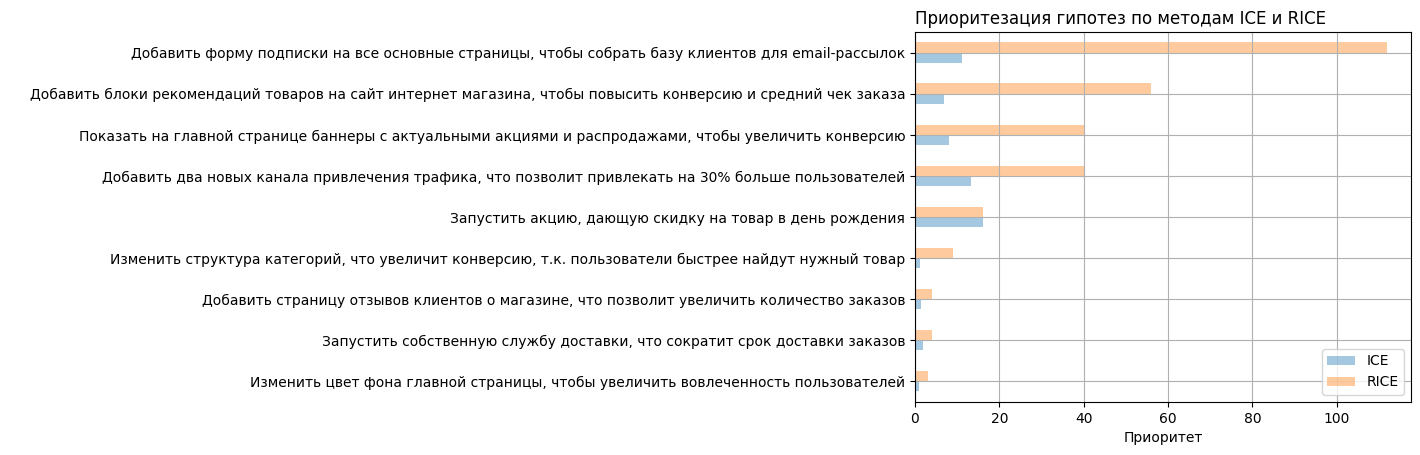

In [16]:
ax = (hypothesis[['hypothesis', 'ICE', 'RICE']]
      .set_index('hypothesis')
      .sort_values('RICE', ascending=True)
      .plot(kind='barh', alpha=0.4)
     )
ax.grid(True)
ax.set_xlabel('Приоритет')
ax.set_ylabel(' ')
ax.set_title('Приоритезация гипотез по методам ICE и RICE', loc='left')
plt.show()

Мы применили 2 самых популярных фреймворка, отобразим на графике получившиеся приоритеты для наглядности.  
Фреймворк RICE, в отличии от ICE использует так же и охват пользователей, на которых повлияют изменения предполгаемые гипотезой.
Как мы можем видеть на графике 4 последние гипотезы были приоритезированы примерно в той же пропорции к 5 верхним - оба фреморка дают полезную информацию. Если значениет охвата является приоритетом, то стоит воспользоваться оценкой по RICE. 

In [17]:
hypothesis[['hypothesis','ICE','RICE']].sort_values(by='RICE', ascending=False).head(5).reset_index(drop=True)

,hypothesis,ICE,RICE
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
4,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2


## 3. Анализ A/B-теста  

### 3.1. Анализ на основе результатов проведенного A/B-теста   

#### 1. Кумулятивные характеристики

Изучим графики кумулятивных, или накапливаемых данных, таким образом мы отследим изменения результатов эксперимента на каждый день тестирования.  
Для этого создадим новый датафрейм с агрегированными данными.

In [18]:
display( 
    orders.columns.values, 
    visitors.columns.values )

array(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'],
      dtype=object)

array(['date', 'group', 'visitors'], dtype=object)

In [19]:
datesGroups = orders[[ 'date','group']].drop_duplicates()

#агрегируем данные о заказах
ordersAggregated = datesGroups.apply(\
    lambda x: orders[np.logical_and ( orders['date'] <= x['date'], 
                                    orders['group'] == x['group'])]\
    .agg({'date' : 'max',
          'group' : 'max',
          'transaction_id' : 'nunique',
          'visitor_id' : 'nunique',
          'revenue' : 'sum'}),\
    axis=1).sort_values(by=['date','group'] )

#агрегируем данные о посетителях
visitorsAggregated = datesGroups.apply(\
    lambda x: visitors[np.logical_and ( visitors['date'] <= x['date'], 
                                      visitors['group'] == x['group'])]\
    .agg({'date' : 'max',
          'group' : 'max',
          'visitors' : 'sum'}),\
    axis=1).sort_values(by=['date','group'] ) 

# объеденим полученные датафреймы и переименуем столбцы для удобства
cumulativeData = ordersAggregated.merge(\
    visitorsAggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [20]:
display (
    orders['date'].max() == cumulativeData['date'].max(),
orders['date'].min() == cumulativeData['date'].min())

True

True

Рассмотрим график кумулятивной выручки по группам.

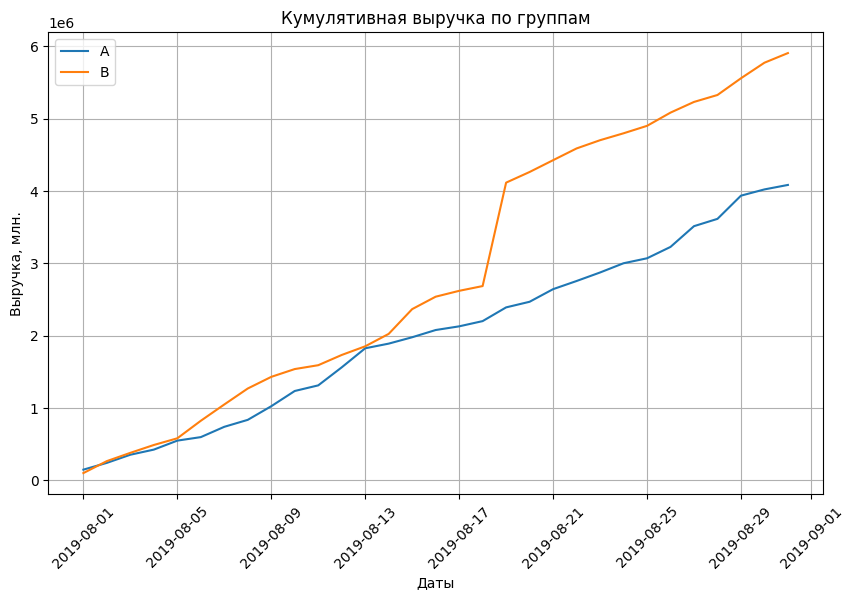

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# выбираем подходящий размер и подписи фигуры
plt.figure(figsize=(10, 6))
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Даты')
plt.ylabel('Выручка, млн.')

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

# делаем график улобным для восприятия
plt.xticks(rotation=45)
plt.legend()
plt.grid(True);

На графике мы видим, что до 13.08.2019 оба сегмента росли с незначительными отличиями. Примерно к 18.08 наблюдается сильный скачек у сегмента "B", после которого он стабильно лидирует. Это нам может говорить либо о возросшем колличестве заказов либо о высоких суммах заказов, в том числе возможны выбросы влияющие на общую картину. 

Рассмотрим график кумулятивного среднего чека.

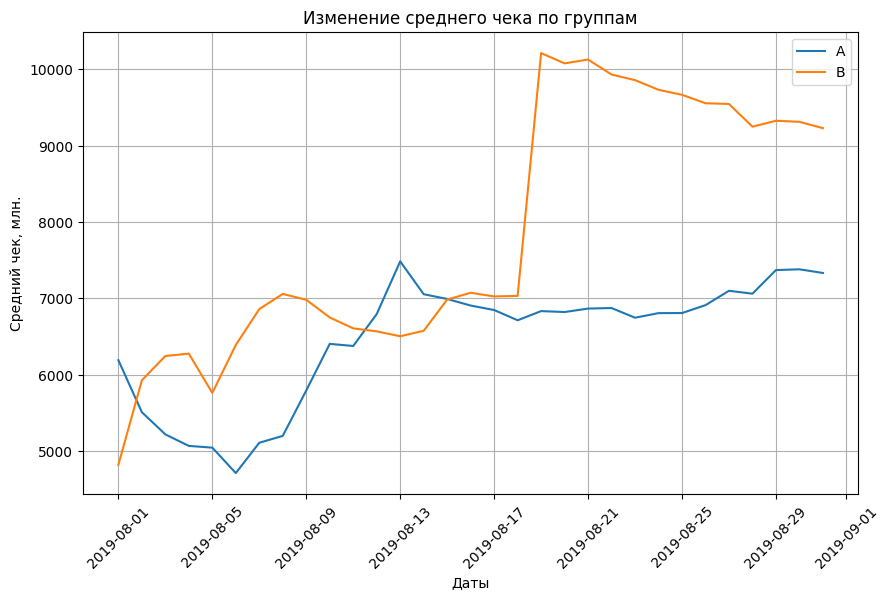

In [22]:
# выбираем подходящий размер и подписи фигуры
plt.figure(figsize=(10, 6))
plt.title('Изменение среднего чека по группам')
plt.xlabel('Даты')
plt.ylabel('Средний чек, млн.')

# строим график для группы А
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 
         label='A')

# строим график для группы B
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 
         label='B')
# делаем график улобным для восприятия
plt.xticks(rotation=45)
plt.grid(True)
plt.legend();

Из графика понятно, что как мы и предположили сегмент B ушел вперед по сумме заказов. Так же как на предыдущем графике виден резкий подьем примерно 18.08.2019 для этого сегмента с последующим плавным спадом. На конец периода сегмент A всё еще ниже чем, не смотря на то что совершил скачёк и  лидировал к 13.08.2019.

Посмотрим и на график относительного изменения кумулятивного среднего чека группы B к группе A.

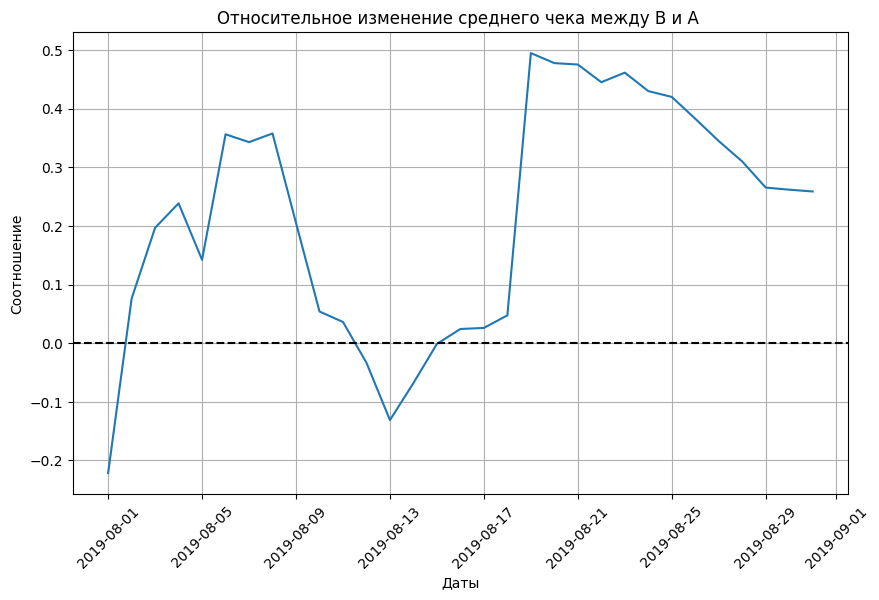

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# выбираем подходящий размер и подписи фигуры
plt.figure(figsize=(10, 6))
plt.title('Относительное изменение среднего чека между B и A ')
plt.xlabel('Даты')
plt.ylabel('Соотношение')

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

plt.xticks(rotation=45)
plt.grid(True);

Мы наблюдаем динамику резкого изменения в нескольких адатах. Существенный провал около 13.08.2019 и уже знакомым нам взлётом около 18.08.2019.
Стоит проверить наличие крупных закахов.

Узнаем как выглядит в динамике куммулятивное среднее колличество заказов на посетителя с разрезом посетителей по группам.

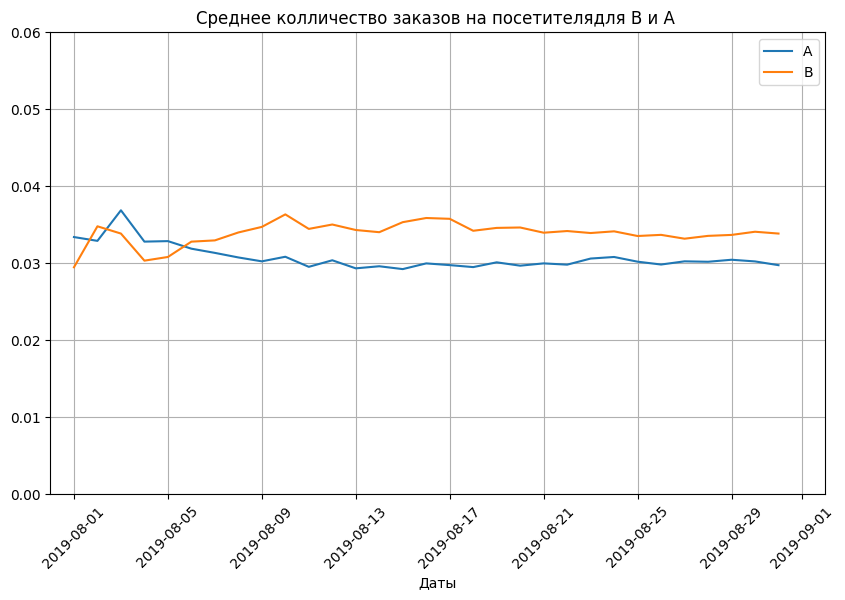

In [24]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# выбираем подходящий размер и подписи фигуры
plt.figure(figsize=(10, 6))
plt.title('Среднее колличество заказов на посетителядля B и A ')
plt.xlabel('Даты')

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 2), 0, 0.06])
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Мы подобрали такой масштаб графика, чтобы можно было увидеть, что флоктуация происходит в дельте 1 процента.
Для наглядности так же приведем график с увеличенным масштабом, но глядя на него может показаться, что график очень нестабильный, но и на нем видно, что кривая выравнивается после 17.08.2019. Сегмент B зафиксировался около 0.34, A - около 0.30.

<div class="alert alert-info">
<b>Софья:</b>
<br> 
</div>

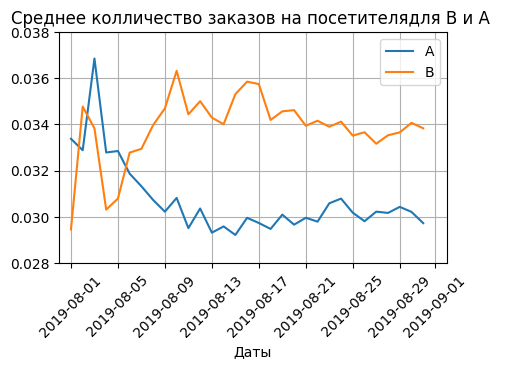

In [25]:
# выбираем подходящий размер и подписи фигуры
plt.figure(figsize=(5, 3))
plt.title('Среднее колличество заказов на посетителядля B и A ')
plt.xlabel('Даты')

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 2), 0, 0.06])
plt.ylim(0.028,0.038)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

В начале теста сегмент A имел большее кумулятивное среднее количество заказов, но постепенно сегмент B выровнялся и зафиксировался примерно около одного значения, больше значения сегмента A. Мы изменили масштаб графика, чтобы было видно, что абсолютное значение колебания в начале и в конце теста не слишком большое: от 3% до 4%. Можно сказать, что среднее количество заказов по группам установилось около своего среднего значения.

Посмотрим и график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

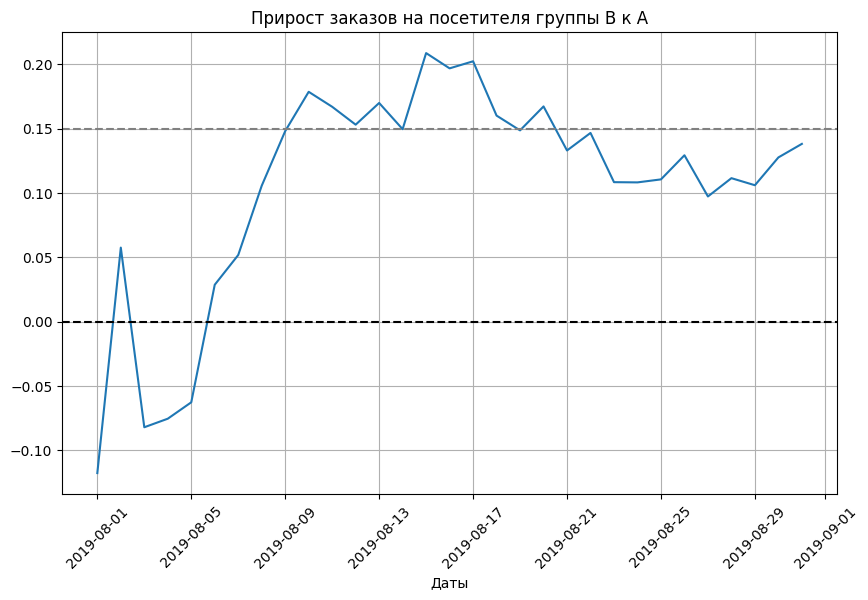

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(\
     cumulativeDataB[['date','conversion']], 
    left_on='date', right_on='date', 
    how='left', 
    suffixes=['A', 'B'])

plt.figure(figsize=(10, 6))
plt.title('Прирост заказов на посетителя группы B к A')
plt.xlabel('Даты')

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

plt.xticks(rotation=45)
plt.grid(True)
plt.show();

На графиче четко видно, что после стремительного скачка с последующим спадом, относительное изменение зафиксировалось и не опускалось ниже 10%.

#### 2. Колличественные характеристики 

Построим точечный график количества заказов по пользователям, чтобы определить есть ли аномалии, обычно пользователи интернет магазинов совершают не больше 2х заказов, особенно если учесть, что мы рассматриваем данные лишь за 2 месяца.

In [27]:
#агрегируем данные по количеству заказов
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'}))

orders_by_users.columns =  ['visitor_id', 'orders']
orders_by_users.head(3)

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,2


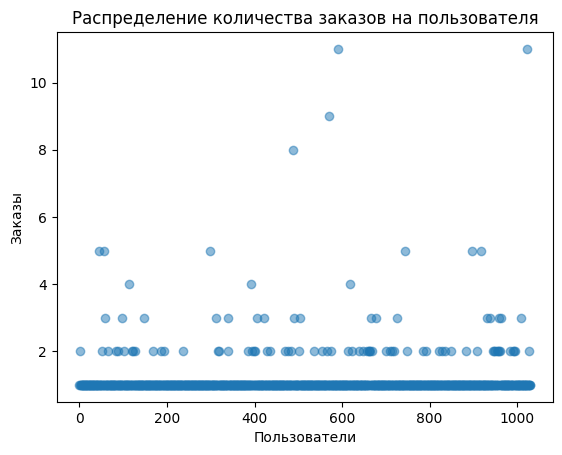

In [28]:
# строим график
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)
plt.title('Распределение количества заказов на пользователя')
plt.ylabel('Заказы')
plt.xlabel('Пользователи')
plt.show()

Как и предполагалось большинство пользователей совершили 1 заказ, но есть и значения больше 4,6,8,11 - они смещают статистики.

Посчитаем  95-й и 99-й перцентили количества заказов на пользователя, чтобы выбрать границу для определения аномальных пользователей.

In [29]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Внось постороим график исключив аномалии.

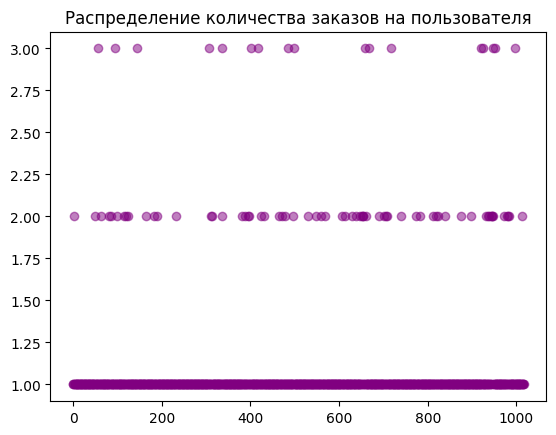

In [30]:
filtered_orders_by_users = orders_by_users[orders_by_users['orders']<4]
x_values = pd.Series(range(0, len(filtered_orders_by_users)))
plt.scatter(x_values, filtered_orders_by_users['orders'],color='purple', alpha=0.5)
plt.title('Распределение количества заказов на пользователя')
plt.show()

Не боллее 1 % пользователей совершили 4 и более покупок, не более 5% пользователей совершили 2 и более покупок. Таким образом граница аномальных пользователей 99 перцентиль.

Продолжим изучение аномалий и построим точечный график стоимостей заказов.

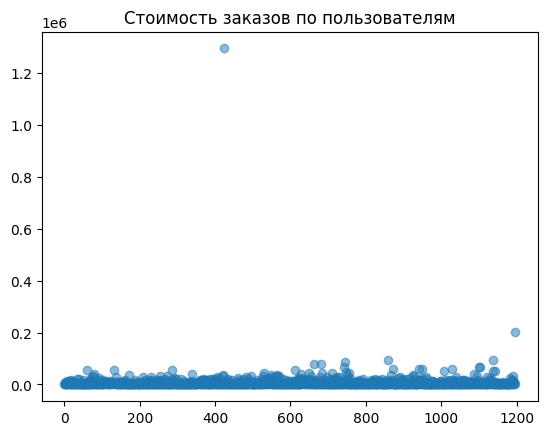

In [31]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('Стоимость заказов по пользователям')
plt.show();

Одинокая точка на вершине графика- определённо выброс.Так же можно сказать и про точку в правом углу выше общего скопления данных.

Посчитаем 95-й и 99-й перцентили стоимости заказов, чтоб точнее выбрать границу для определения аномальных заказов.

In [32]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Посмотрим как будет выглядеть график, если убрать аномалии по 99 перцентелю, возьмём значение 58233.

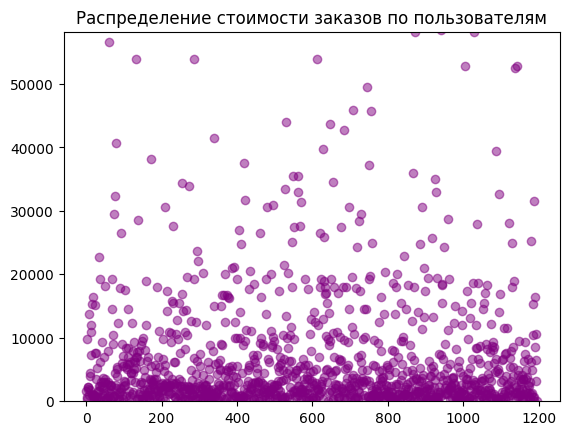

In [33]:
plt.ylim(0, 58233)
plt.scatter(x_values, orders['revenue'], color='purple', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

#### Промежуточный вывод 1

Во втором разделе мы оценили результаты A/B-теста визуально и выяснили, что в данных есть выбросы.  
Мы нашли границу для их определения - 99 перцентиль.

#### 3. Статистическая значимость

Теперь же посмотрим на разницу между группами, нас интересует различия:
-  в среднем количестве заказов на посетителя по «сырым» данным (без удаления аномальных пользователей) и по очищенным данным;
-  в среднем чеке заказов по «сырым» данным и по очищенным данным.  

**Нулевая гипотеза**: статистически значимых различий между группами нет.   
**Альтернативная**: статистически значимые различия между группами есть.  
Возьмём общепринятый **уровень статистичесой значимости** равный 0.05.  
Для проверки будем использовать **тест Манна-Уитни**, поскольку исследуемые величины распределена не нормально.

#### Подготовка данных и функций

In [34]:
# подготовим данные разделив visitors на датафреймы для сегментов A и B

visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}),axis=1,)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}),axis=1,)

visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

# подготовим данные orders на датафреймы для сегментов A и B

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),axis=1,).sort_values(by=['date'])
orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),axis=1,).sort_values(by=['date'])
orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']

#объеденим данные
stat_data = (orders_daily_a
    .merge(orders_daily_b, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left'))

В результате подготовки данных у нас получился объединённый датафрейм где для обоих сегментов  A и B отдельно на указанную в 1м столбце дату приводится следующая информация: 
- колличество заказов на дату (orders_daily_a, orders_daily_b)
- суммарная выручка на дату (revenue_per_date_a, revenue_per_date_b)
- суммарное число заказов по дату включительно (orders_cummulative_a, orders_cummulative_b ) 
- суммарная выручка по дату включительно (revenue_cummulative_a, revenue_cummulative_b)
- количество пользователей на дату (visitors_per_date_a, visitors_per_date_b)е- количество пользователей по дату включительно (visitors_cummulative_a, visitors_cummulative_b)в группе B. в группе B.

In [35]:
stat_data.head(1)

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713


Объявим orders_by_users_a и orders_by_users_b - для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [36]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']
display(
    orders_by_users_b.head(1),orders_by_users_a.head(1))

,visitor_id,orders
0,5114589,1


,visitor_id,orders
0,8300375,1


Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.  
Это последний шаг подготовки к проверке критерием Манна-Уитни.

In [37]:
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(stat_data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(stat_data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0)

Поскольку проверку мы будем проводить несколько раз, создадим функцию stat_f.

In [38]:
def stat_f(data_a, data_b):
    alpha = 0.05
    p_value = st.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.2f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть  разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
    print("Относительный прирост В к А: {0:.2%}".format(data_b.mean() / data_a.mean()-1))

#### Проведение теста по неочищенным данным

Переходим непосредственно к проверке по "сырым" данным. Мы проверим влияние нововведения на средний чек и колличество заказов.

***Нулевая гипотеза***: статистически значимых различий в `среднем количестве заказов` на посетителя между группами `нет`.  
***Альтернативная***: статистически значимые различия в `среднем количестве заказов` на посетителя между группами `есть`.  

In [39]:
stat_f(sample_a, sample_b)

P-value: 0.02
Отвергаем нулевую гипотезу: между группами есть  разница
Относительный прирост В к А: 13.81%


***Нулевая гипотеза***: статистически значимых различий в `среднем чеке заказов` между группами `нет`.
***Альтернативная***: статистически значимые различия в `среднем чеке заказов` между группами `есть`.

In [40]:
stat_f(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.73
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.87%


#### Промежуточный вывод 2 
По **неочищенным данным** статистическески значимая разница в среднем количестве заказов на посетителя между группами есть, прирост В к А составляет 13.81%, одновременно с этим разницы нет  в среднем чеке заказ.


#### Проведение теста по очищенным данным

Перейдём к очищенным данным, создадим датафрейм abnormal_users. Для этого нам потребуется сделать среды по 99 перцентилям, как мы определили выше: users_with_many_orders, users_with_expensive_orders.

In [41]:
users_with_many_orders = pd.concat(
    [orders_by_users_a[orders_by_users_a['orders'] > np.percentile(orders_by_users['orders'], 99)]['visitor_id'],
     orders_by_users_b[orders_by_users_b['orders'] > np.percentile(orders_by_users['orders'], 99)]['visitor_id'],
    ],axis=0,)

users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values())

abnormal_users.head(5)

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

In [42]:
abnormal_users.shape[0]

15

Всего мы нашли 15 пользователей, которые могли существенно повлиять на данные.   
Проверим статистическую значимость, отфильтровав в данных этих пользователей.

In [43]:
sample_a_filtered = pd.concat([
        orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(stat_data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])),name='orders',),],
        axis=0,)

sample_b_filtered = pd.concat([
        orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))]['orders'],
        pd.Series(0,index=np.arange(stat_data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),name='orders',),],
        axis=0,)

***Нулевая гипотеза***: статистически значимых различий в `среднем количестве заказов` на посетителя между группами `нет`.  
***Альтернативная***: статистически значимые различия в `среднем количестве заказов` на посетителя между группами `есть`.  

In [44]:
stat_f(sample_a_filtered, sample_b_filtered)

P-value: 0.01
Отвергаем нулевую гипотезу: между группами есть  разница
Относительный прирост В к А: 15.33%


***Нулевая гипотеза***: статистически значимых различий в `среднем чеке заказов` между группами `нет`.
***Альтернативная***: статистически значимые различия в `среднем чеке заказов` между группами `есть`.

In [45]:
stat_f(
    orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'])

P-value: 0.85
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -0.57%


#### Промежуточный вывод 3
По **очищенным данным** статистическески значимая разница в среднем количестве заказов на посетителя между сегментами A и B тоже есть, прирост - 15.33%, одновременно с этим разницы нет в среднем чеке заказа тоже нет.

### 3.2. Принятие решения по результатам теста 

Мы предлагаем остановить тест и зафиксировать победу сегмента B. 

Полученные данные говорят о том, что после “очистки” данных (то есть удаления аномальных значений) статистически значимая разница в среднем количестве заказов на посетителя между группами A и B все еще присутствует и даже увеличивается (с 13.81% до 15.33%). Это подтверждает, что изменения, внедренные в группе B, увеличивают активность пользователей.  

Однако, как и в случае с неочищенными данными, нет статистически значимой разницы в среднем чеке заказа между группами. Это говорит нам о том, средняя стоимость этих заказов не отличается от средней стоимости заказов в группе A.   

Таким образом мы приходим к выводу, что данные подтверждают позитивные изменения после внедренных изменений в группе B: у нашего интернет магазина увеличилась активность пользователей (больше заказов) при сохранении средней стоимости заказов. 


## Вывод

Совместно с отделом аналитики и маркетинга были подготовлены 9 гипотез.
В ходе исследования мы определили их приоритет и обнаружили, что при использовании 2х разных фреймворков мы получаем одинаковый список топ-5 гипотез.  Если значениет охвата является приоритетом, то стоит воспользоваться оценкой по RICE, поскольку гипотезы приоритизируется в зависимости от охвата в разной последовательности:
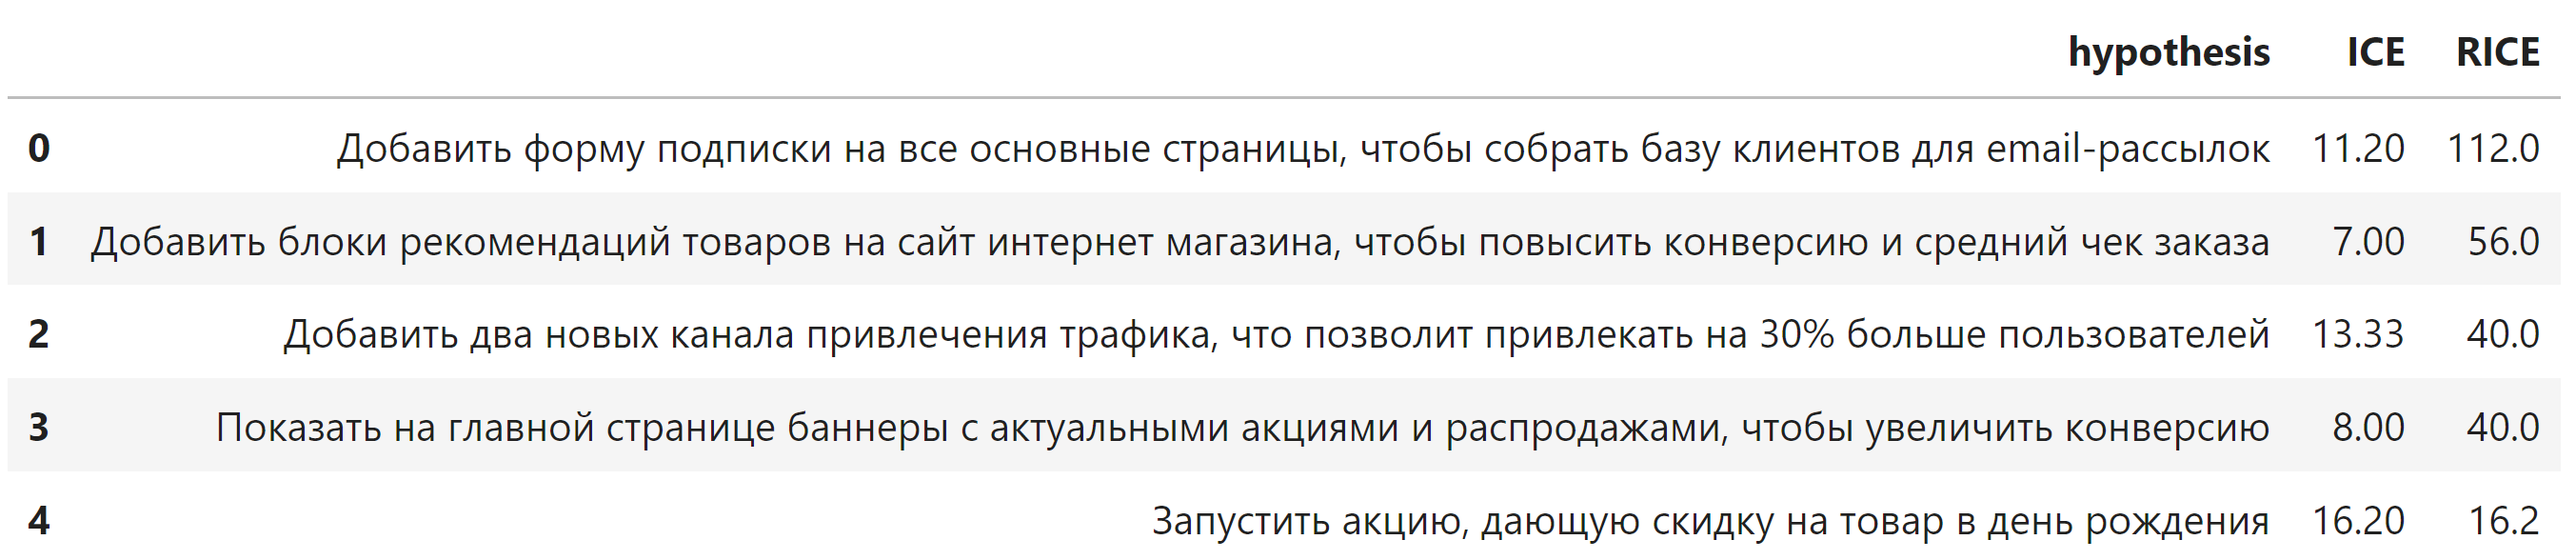

На основе данных проведенного A/B теста мы рассмотрели и визуализировали кумулятивные характеристики (выручка, средний чек,относительное изменение среднего чека между группами, среднее колличество заказов, припрос заказов), колличественные характеристики (колличество заказов на пользователя, стоимость заказов по пользователям). В результате мы определили, что в данных есть выбросы и решили принять за границу 99 перцентиль в данных. Для заказов она составляет - 4 и более заказа, для стоимости заказов - 58233 р.   
Мы провели статистическую значимости различий между группами по чеочищенным данным и по данным без аномали. На основании проведенного теста Манна-Уитни
 предлагаем остановить тест и зафиксировать победу сегмента B. Мы наблюдаем позитивные изменения после внедренных изменений в группе B: у нашего интернет магазина увеличилась активность пользователей (больше заказов) при сохранении средней стоимости заказов. С статистически значимая разница в среднем количестве заказов на посетителя между группами A и ще присутствует становится больше после очистки данныхс (с 13.81% до 15.3 % Вместе с темнами, нет статистически значимой разницы в среднем чеке заказа между груп, даже после очистки данныхпаказов.